## Alex Gromadzki
## arg2eu
1. Create a context
2. Preparation of data (get it inot parquet)
3. MLlib based analysis
4. Visualization

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

import matplotlib.pyplot as plt

# Create Context

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
# sc
# sqlc

# Prepare Data
* Reading in CSV to pddf
* Converting to spark df
* Writing out to parquet
* Reading back in with parquet

### Write parquet to s3

In [3]:
# setup temp dataframe
bucket='odl-spark19spds6003-001'
data_key = 'Batting.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)
pddf.dropna(inplace=True)
pd.options.display.max_columns = None
pddf

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
4560,colemjo02,1890,1,PHI,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
5088,brynato01,1891,1,BSN,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
5177,dunnian01,1891,1,NY1,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
5415,sulliji01,1891,1,BSN,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
5747,viaule01,1892,1,CL4,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
5902,johnsab01,1893,1,CHN,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
6285,scheija01,1894,1,PHI,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
6296,sommean01,1894,1,BRO,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
6319,terryad01,1894,1,PIT,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
6321,thomato01,1894,1,CL4,NL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
pddf.groupby('playerID').count().yearID

playerID
aardsda01     9
aaronha01    22
aaronto01     7
aasedo01     13
abadan01      3
abadfe01      8
abbotgl01    12
abbotje01     5
abbotji01    11
abbotku01    10
abbotky01     4
abbotpa01    12
aberal01      4
abercre01     3
abernbr01     5
abernte02    17
abernwo01     1
abnersh01     7
abramca01     2
abregjo01     1
abreubo01    20
abreujo02     3
abreuju01     1
abreuto01     6
abreuwi01     4
accarje01    10
aceveal01     7
acevejo01     5
aceveju01    10
achteaj01     3
             ..
zelleba01     1
zeppbi01      3
zerbech01     4
zernigu01     5
zieglbr01    11
ziemst01      1
zimmedo01    13
zimmeje01     8
zimmeje02     3
zimmejo01     1
zimmejo02     8
zimmery01    12
zinkch01      1
zinsebi01     1
zinteal01     2
zipfebu01     2
ziskri01     13
zitoba01     15
zobribe01    12
zoccope01     1
zoskyed01     5
zuberjo01     2
zuletju01     2
zumayjo01     5
zuninmi01     4
zupcibo01     5
zupofr01      3
zuvelpa01     9
zuverge01     8
zychto01      2
Name: yearID, L

In [5]:
# parquetPath = '/home/ec2-user/SageMaker/arg2eu/tmp2-pqt-arg2eu'
# df = sqlc.createDataFrame(pddf)
# df.write.parquet(parquetPath)


# cannot do this because the path is taken

### Write to spark dataframe from parquet

In [6]:
parquetPath = '/home/ec2-user/SageMaker/arg2eu/tmp2-pqt-arg2eu'
df = sqlc.read.parquet(parquetPath)
df

DataFrame[playerID: string, yearID: bigint, stint: bigint, teamID: string, lgID: string, G: bigint, AB: bigint, R: bigint, H: bigint, 2B: bigint, 3B: bigint, HR: bigint, RBI: double, SB: double, CS: double, BB: bigint, SO: double, IBB: double, HBP: double, SH: double, SF: double, GIDP: double]

## MLlib Basics


In [7]:
display(df)

DataFrame[playerID: string, yearID: bigint, stint: bigint, teamID: string, lgID: string, G: bigint, AB: bigint, R: bigint, H: bigint, 2B: bigint, 3B: bigint, HR: bigint, RBI: double, SB: double, CS: double, BB: bigint, SO: double, IBB: double, HBP: double, SH: double, SF: double, GIDP: double]

In [8]:
df.printSchema()

root
 |-- playerID: string (nullable = true)
 |-- yearID: long (nullable = true)
 |-- stint: long (nullable = true)
 |-- teamID: string (nullable = true)
 |-- lgID: string (nullable = true)
 |-- G: long (nullable = true)
 |-- AB: long (nullable = true)
 |-- R: long (nullable = true)
 |-- H: long (nullable = true)
 |-- 2B: long (nullable = true)
 |-- 3B: long (nullable = true)
 |-- HR: long (nullable = true)
 |-- RBI: double (nullable = true)
 |-- SB: double (nullable = true)
 |-- CS: double (nullable = true)
 |-- BB: long (nullable = true)
 |-- SO: double (nullable = true)
 |-- IBB: double (nullable = true)
 |-- HBP: double (nullable = true)
 |-- SH: double (nullable = true)
 |-- SF: double (nullable = true)
 |-- GIDP: double (nullable = true)



In [9]:
# df.take(5)
# df.head(5) # same thing

In [10]:
print("Pearson's r(SF,RBI) = {}".format(df.corr("SF", "RBI")))
print("Pearson's r(SB,RBI) = {}".format(df.corr("SB", "RBI")))

Pearson's r(SF,RBI) = 0.8335810213083181
Pearson's r(SB,RBI) = 0.4661303796521686


This makes sense, considering you don't want to bunt if you are trying to score (RBI).  Maybe something more interesting.

In [11]:
print("Pearson's r(HBP,HR) = {}".format(df.corr("HBP", "HR"))) # Hit by Pitch vs. Home Runs
print("Pearson's r(HBP,H) = {}".format(df.corr("HBP", "H")))   # Hit by Pitch vs. Hits
print("Pearson's r(HR,H) = {}".format(df.corr("HR", "H")))     # Home Runs vs. Hits
print("Pearson's r(BB,HR) = {}".format(df.corr("BB", "HR")))   # Base on Ball vs. Home Runs
print("Pearson's r(BB,H) = {}".format(df.corr("BB", "H")))     # Base on Ball vs. Hits

print('\n')
print("Pearson's r(G,HBP) = {}".format(df.corr("G", "HBP")))   # Games vs. Hit by Pitch
print("Pearson's r(G,HR) = {}".format(df.corr("G", "HR")))     # Games vs. Home Runs
print("Pearson's r(G,H) = {}".format(df.corr("G", "H")))       # Games vs. Hits
print("Pearson's r(G,BB) = {}".format(df.corr("G", "BB")))     # Games vs. Base on Ball



Pearson's r(HBP,HR) = 0.5964622994957308
Pearson's r(HBP,H) = 0.6518029555047087
Pearson's r(HR,H) = 0.7989849986141668
Pearson's r(BB,HR) = 0.8068359947440594
Pearson's r(BB,H) = 0.8832315915431842


Pearson's r(G,HBP) = 0.6109827445681959
Pearson's r(G,HR) = 0.7313882656988067
Pearson's r(G,H) = 0.9179755244596672
Pearson's r(G,BB) = 0.8409492348823674


* Great, so as we saw in the demo, hits and games are pretty closely correlated.
* Homeruns are less so correlated with the number of games, and slightly more with the number of overall hits
* What is interesting to me is that the raw correlation of base on ball is more correlated to hits than home runs

Let's convert these to "per game" stats as we did in the demo

In [12]:
df = df.withColumn('HpG', df.H / df.G)
df = df.withColumn('HRpG', df.HR / df.G)
df = df.withColumn('HBPpG', df.HBP / df.G)
df = df.withColumn('BBpG', df.BB / df.G)
df = df.withColumn('SLG', df.H/df.AB)
df.printSchema()

root
 |-- playerID: string (nullable = true)
 |-- yearID: long (nullable = true)
 |-- stint: long (nullable = true)
 |-- teamID: string (nullable = true)
 |-- lgID: string (nullable = true)
 |-- G: long (nullable = true)
 |-- AB: long (nullable = true)
 |-- R: long (nullable = true)
 |-- H: long (nullable = true)
 |-- 2B: long (nullable = true)
 |-- 3B: long (nullable = true)
 |-- HR: long (nullable = true)
 |-- RBI: double (nullable = true)
 |-- SB: double (nullable = true)
 |-- CS: double (nullable = true)
 |-- BB: long (nullable = true)
 |-- SO: double (nullable = true)
 |-- IBB: double (nullable = true)
 |-- HBP: double (nullable = true)
 |-- SH: double (nullable = true)
 |-- SF: double (nullable = true)
 |-- GIDP: double (nullable = true)
 |-- HpG: double (nullable = true)
 |-- HRpG: double (nullable = true)
 |-- HBPpG: double (nullable = true)
 |-- BBpG: double (nullable = true)
 |-- SLG: double (nullable = true)



In [13]:
print("Pearson's r(HBP,HR) = {}".format(df.corr("HBP", "HR"))) # Hit by Pitch vs. Home Runs
print("Pearson's r(HBP,H) = {}".format(df.corr("HBP", "H")))   # Hit by Pitch vs. Hits
print("Pearson's r(HR,H) = {}".format(df.corr("HR", "H")))     # Home Runs vs. Hits
print("Pearson's r(BB,HR) = {}".format(df.corr("BB", "HR")))   # Base on Ball vs. Home Runs
print("Pearson's r(BB,H) = {}\n".format(df.corr("BB", "H")))     # Base on Ball vs. Hits

print("Pearson's r(G,HRpG) = {}".format(df.corr("G", "HRpG")))     # G vs. HR/G
print("Pearson's r(HRpG,HBPpG) = {}".format(df.corr("HRpG", "HBPpG")))   # HR/G vs. HBP/G
print("Pearson's r(HRpG,BBpG) = {}\n".format(df.corr("HRpG", "BBpG")))   # HR/G vs. BB/G


print("Pearson's r(G,HpG) = {}".format(df.corr("G", "HpG")))       # Games vs. H/G
print("Pearson's r(HpG,HBPpG) = {}".format(df.corr("HpG", "HBPpG")))   # H/G vs. HBP/G
print("*** Pearson's r(HpG,BBpG) = {} ***\n".format(df.corr("HpG", "BBpG")))   # H/G vs. BB/G


print("Pearson's r(G,HBPpG) = {}".format(df.corr("G", "HBPpG")))   # Games vs. HBP/G
print("Pearson's r(G,BBpG) = {}\n".format(df.corr("G", "BBpG")))     # Games vs. BB/G
print("Pearson's r(G,SLG) = {}".format(df.corr("G", "SLG")))   # Games vs. SLG
print("Pearson's r(HRpG,SLG) = {}".format(df.corr("HRpG", "SLG")))   # Games vs. SLG

Pearson's r(HBP,HR) = 0.5964622994957308
Pearson's r(HBP,H) = 0.6518029555047087
Pearson's r(HR,H) = 0.7989849986141668
Pearson's r(BB,HR) = 0.8068359947440594
Pearson's r(BB,H) = 0.8832315915431842

Pearson's r(G,HRpG) = 0.5763895784052703
Pearson's r(HRpG,HBPpG) = 0.31734119097145624
Pearson's r(HRpG,BBpG) = 0.6241568461711046

Pearson's r(G,HpG) = 0.7333576164062421
Pearson's r(HpG,HBPpG) = 0.3817848350493549
*** Pearson's r(HpG,BBpG) = 0.7514542914067218 ***

Pearson's r(G,HBPpG) = 0.2855104528098152
Pearson's r(G,BBpG) = 0.6264110833470401

Pearson's r(G,SLG) = 0.4673923582563979
Pearson's r(HRpG,SLG) = 0.4500968454181979


### Select two features for analysis
* HpG = feature
* BBpG = label

In [14]:
df = df.select("HpG", "BBpG")
df

DataFrame[HpG: double, BBpG: double]

## Finally, ML time
1. split data into train/test
2. **SPARK SPECIAL SAUCE** -  pysparki.ml.linalg - vectorization
3. Train --> Predict --> Evaluate

### Make Training and Test sets

In [15]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 52830, test set N = 13345


# VECTORIZATION - spark special sauce

In [16]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy

https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql-udfs.html
* User-Defined Functions (aka UDF) is a feature of Spark SQL to define new Column-based functions that extend the vocabulary of Spark SQL’s DSL for transforming Datasets.

In [17]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("BBpG", "oneElementVec(HpG) as HpG")
testDF = testDF.selectExpr("BBpG", "oneElementVec(HpG) as HpG")

print(testDF.orderBy(testDF.BBpG.desc()).limit(5))

DataFrame[BBpG: double, HpG: vector]


In [18]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("BBpG", "label").withColumnRenamed("HpG", "features")
testDF = testDF.withColumnRenamed("BBpG", "label").withColumnRenamed("HpG", "features")

## ML time for real
1. Train
2. Predict
3. Evaluate

In [19]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [20]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

We are now going to transform our test set to get predictions. It will append a prediction column to testDF in the new dataframe predictionsAndLabelsDF.

In [21]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=2.0, features=DenseVector([3.0]), prediction=0.9971767741313023), Row(label=1.4, features=DenseVector([0.4]), prediction=0.14733178703954933), Row(label=1.3846153846153846, features=DenseVector([1.042]), prediction=0.35716441160927204), Row(label=1.3333333333333333, features=DenseVector([0.0]), prediction=0.016586404410048845), Row(label=1.1568627450980393, features=DenseVector([1.0196]), prediction=0.349858948367599)]


## Model Evaluation

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [23]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [24]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

0.11386942982688969

In [25]:
abs(eval.setMetricName("r2").evaluate(predictionsAndLabelsDF))

0.5618634640709226

# Plotting
* giving me issues when i try to use the full dataset!

In [26]:
# plt.scatter([1,2,3], [1,2,3], alpha=0.5) # this works

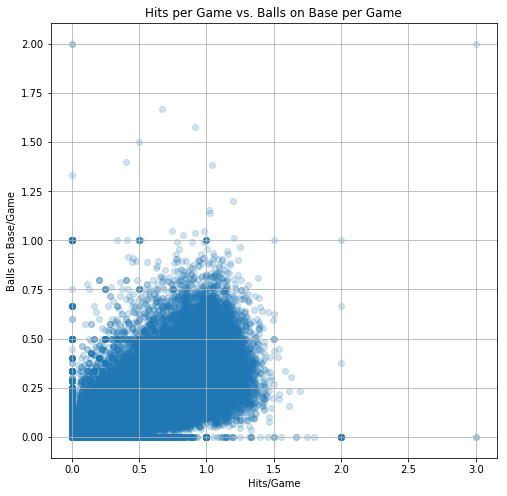

In [31]:
# MPL
data = df.toPandas() # had to convert to pandas in order to plot using mpl 
data = (data['HpG'],data['BBpG'])
# Create plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.scatter(data[0], data[1], alpha=0.2)
plt.title("Hits per Game vs. Balls on Base per Game")
plt.ylabel("Balls on Base/Game")
plt.xlabel("Hits/Game")
plt.grid(True)
plt.show()